In [1]:
import os
import numpy as np
from nibabel.testing import data_path
import nibabel as nib
import matplotlib.pyplot as plt
import cv2
import pandas as pd

from nonlocalunet.models import NonLocalUnet
    
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

import random
from torch.utils.tensorboard import SummaryWriter

from trainer.utils import open_ct, open_mask
from nonlocalunet.infer import pad, tile
from tqdm.notebook import tqdm

In [2]:
def save_tails(idx, shape, save_path = 'data/processed'):
    img, mask = open_ct(idx), open_mask(idx)
    img = pad(img, shape)
    img = tile(img, shape)

    mask = pad(mask, shape)
    mask = tile(mask, shape)

    s = mask.shape
    vox_area = s[1] * s[2] * s[3]
    zero_mask = 0
    vox_num = 0
    im_path = os.path.join(save_path, 'images', str(idx))
    mask_path = os.path.join(save_path, 'masks', str(idx))
    os.makedirs(im_path, exist_ok=True)
    os.makedirs(mask_path, exist_ok=True)
    for i in range(img.shape[0]):
        if (mask[i]==0).sum()/vox_area > 0.95:
            zero_mask += 1
            continue
        np.save(os.path.join(im_path, f'{vox_num}.npy'), img[i])
        np.save(os.path.join(mask_path, f'{vox_num}.npy'), mask[i])
        vox_num += 1

In [4]:
import multiprocessing
from joblib import Parallel, delayed
num_cores = 4 # number of cores to use
#multiprocessing.cpu_count()
shape = (64, 128, 128)
list_to_iterate = [(i, shape) for i in range(140)]
result_list = Parallel(n_jobs=num_cores)(delayed(save_tails)(i, j) for i, j in tqdm(list_to_iterate))

  0%|          | 0/140 [00:00<?, ?it/s]

In [5]:
impath = 'data/processed/images/'
maskpath = 'data/processed/masks/'
result = []
pathes = []
mask_pathes = []
for i in range(140):
    path = os.listdir(f'{impath}{i}')
    path = [f'{impath}{i}/{vox}' for vox in path]
    pathes += path
    mask_path = os.listdir(f'{maskpath}{i}')
    mask_path = [f'{maskpath}{i}/{vox}' for vox in mask_path]
    mask_pathes += mask_path
    result += [i]*len(path)

In [6]:
df = pd.DataFrame({'volume': result, 'path': pathes, 'mask': mask_pathes})

In [7]:
df.to_csv('data/processed/df.csv', index=False)

NameError: name 'img' is not defined

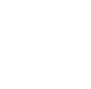

In [7]:
plt.figure(figsize=(13,13))
for i in range(32):
    plt.subplot(8,8, i+1)
    plt.axis('off')
    plt.imshow(img[i])